In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

In [3]:
using ReactiveMP, Rocket, GraphPPL, Distributions, Random
using CairoMakie
using BenchmarkTools, DataFrames, Query

import ReactiveMP: update!

### Hierarchical Gaussian Filter

In this demo the goal is to perform approximate variational Bayesian Inference for Univariate Hierarchical Gaussian Filter (HGF).

Simple HGF model can be defined as:

$$
\begin{equation}
  \begin{aligned}
    x^{(j)}_k & \sim \, \mathcal{N}(x^{(j)}_{k - 1}, f_k(x^{(j - 1)}_k)) \\
    y_k & \sim \, \mathcal{N}(x^{(j)}_k, \tau_k)
  \end{aligned}
\end{equation}
$$

where $j$ is an index of layer in hierarchy, $k$ is a time step and $f_k$ is a variance activation function. `ReactiveMP.jl` export Gaussian Controlled Variance (GCV) node with $f_k = \exp(\kappa x + \omega)$ variance activation function. By default uses Gauss-Hermite cubature with a prespecified number of approximation points in the cubature. We can change the number of points in Gauss-Hermite cubature with the help of metadata structures in `ReactiveMP.jl`. 

$$
\begin{equation}
  \begin{aligned}
    z_k & \sim \, \mathcal{N}(z_{k - 1}, \mathcal{\tau_z}) \\
    x_k & \sim \, \mathcal{N}(x_{k - 1}, \exp(\kappa z_k + \omega)) \\
    y_k & \sim \, \mathcal{N}(x_k, \mathcal{\tau_y})
  \end{aligned}
\end{equation}
$$

In this experiment we will create a single time step of the graph and perform variational message passing filtering alrogithm to estimate hidden states of the system.

For simplicity and smooth reactive graphs we will consider $\tau_z$, $\tau_y$, $\kappa$ and $\omega$ known and fixed.

### Data

For testing purposes we can use synthetically generated data where underlying data generation process matches our model specification.

In [4]:
params = let 
    
    seed = 123
    
    n    = 250
    τ_z  = 20.0
    τ_y  = 5.0
    
    κ = 1.0
    ω = 0.0
    
    # for inference later
    nitr = 10
    gh_n = 9

    @strdict seed n τ_z τ_y κ ω nitr gh_n
end;

In [5]:
z, s, y = generate_data(HGFModel(), params);

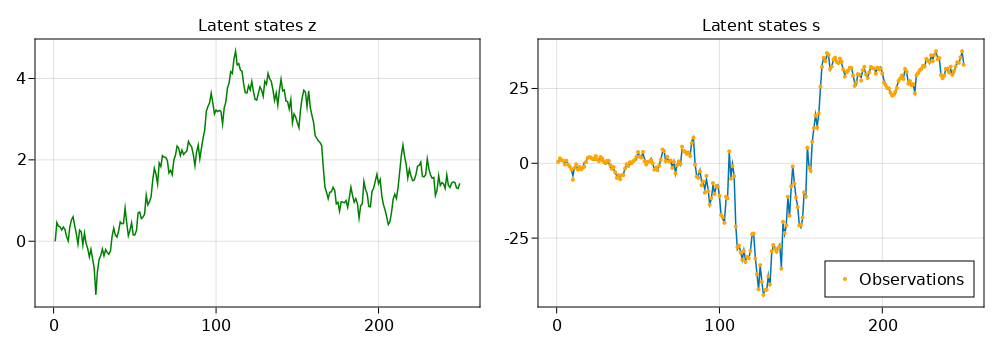

In [6]:
let 
    f = Figure(resolution = (1000, 350))
    
    range = 1:length(z)
    
    ax1 = Axis(f[1, 1], title = "Latent states z")
    ax2 = Axis(f[1, 2], title = "Latent states s")
    
    lines!(ax1, range, z, color = :green)
    
    lines!(ax2, range, s)
    scatter!(ax2, range, y, label = "Observations", markersize = 4, color = :orange)
    
    axislegend(ax2, position = :rb)
    
    f
end

### Model specification

In [7]:
@model function hgf(gh_n, τ_z, τ_y, κ, ω)

    # First as usual we create a placeholder inputs for our priors
    zv_prior = datavar(Float64, 2)
    sv_prior = datavar(Float64, 2)

    zv_min ~ NormalMeanPrecision(zv_prior[1], zv_prior[2])
    sv_min ~ NormalMeanPrecision(sv_prior[1], sv_prior[2])

    # Z-layer random walk 
    zv ~ NormalMeanPrecision(zv_min, τ_z) where { q = q(zv_min, zv)q(τ_z) }

    # We use Gauss Hermite approximation to approximate
    # nonlinearity between layers in hierarchy
    meta = GCVMetadata(GaussHermiteCubature(gh_n))

    # S-layer GCV with structured factorisation
    gcv, sv ~ GCV(sv_min, zv, κ, ω) where { 
        q = q(sv, sv_min)q(zv)q(κ)q(ω), meta = meta 
    }

    yv = datavar(Float64)
    yv ~ NormalMeanPrecision(sv, τ_y)

    return zv_prior, sv_prior, gcv, zv, sv, yv
end

hgf (generic function with 1 method)

### Inference specification

In [8]:
mutable struct HGFInferenceAgent{P, M, O, K, F, H, S} <: Actor{Float64}
    params        :: P
    model         :: M
    model_output  :: O
    n_iterations  :: Int
    zm            :: K
    sm            :: K
    fe            :: F
    hold          :: H
    subscriptions :: S
    current_s     :: Tuple{Float64, Float64}
    current_z     :: Tuple{Float64, Float64}
end

Base.show(io::IO, agent::HGFInferenceAgent) = print(io, "HGFInferenceAgent()")

function HGFInferenceAgent(params)
    @unpack nitr, gh_n, τ_z, τ_y, κ, ω = params

    zm = keep(Marginal)
    sm = keep(Marginal)
    fe = ScoreActor(Float64)

    # We create a single time section of a full graph here
    model, model_output = hgf(gh_n, τ_z, τ_y, κ, ω)

    zv_prior, sv_prior, gcv, zv, sv, yv = model_output

    hold = PendingScheduler()

    current_s = (0.0, inv(5.0))
    current_z = (0.0, inv(5.0))

    zmsub = subscribe!(getmarginal(zv) |> schedule_on(hold), zm)
    smsub = subscribe!(getmarginal(sv) |> schedule_on(hold), sm)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    subscriptions = (zmsub, smsub, fesub)

    # We set an initial joint marginal around GCV node to be able 
    # to start inference procedure
    setmarginal!(gcv, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))
    setmarginal!(sv, NormalMeanPrecision(current_s...))
    setmarginal!(zv, NormalMeanPrecision(current_z...))

    return HGFInferenceAgent(params, model, model_output, nitr, zm, sm, fe, hold, subscriptions, current_s, current_z) 
end

getresults(agent::HGFInferenceAgent) = map(getvalues, (agent.fe, agent.zm, agent.sm))

function Rocket.on_next!(agent::HGFInferenceAgent, data::Float64)
    zv_prior, sv_prior, gcv, zv, sv, yv = agent.model_output
    # To perform multiple VMP iterations we pass our data multiple times
    # It forces an inference backend to react on data multiple times and 
    # hence update posterior marginals multiple times
    for i in 1:agent.n_iterations
        update!(zv_prior[1], agent.current_z[1])
        update!(zv_prior[2], agent.current_z[2])
        update!(sv_prior[1], agent.current_s[1])
        update!(sv_prior[2], agent.current_s[2])
        update!(yv, data)
    end

    release!(agent.fe)
    release!(agent.hold)

    # Update current posterior marginals at time step k
    agent.current_s = mean_precision(last(agent.sm))
    agent.current_z = mean_precision(last(agent.zm))
end

function Rocket.on_complete!(agent::HGFInferenceAgent)
    unsubscribe!(agent.subscriptions)
end

In [9]:
function inference(source, params)
    agent        = HGFInferenceAgent(params)
    subscription = subscribe!(source, agent)
    return subscription, getresults(agent)
end

inference (generic function with 1 method)

In [10]:
agent             = HGFInferenceAgent(params)
data_source       = from(y)
data_subscription = subscribe!(data_source, agent);

In [11]:
fe, zm, sm = getresults(agent);

average_mse(z, zm) = 184.70622535949857
average_mse(s, sm) = 97.51797040664998


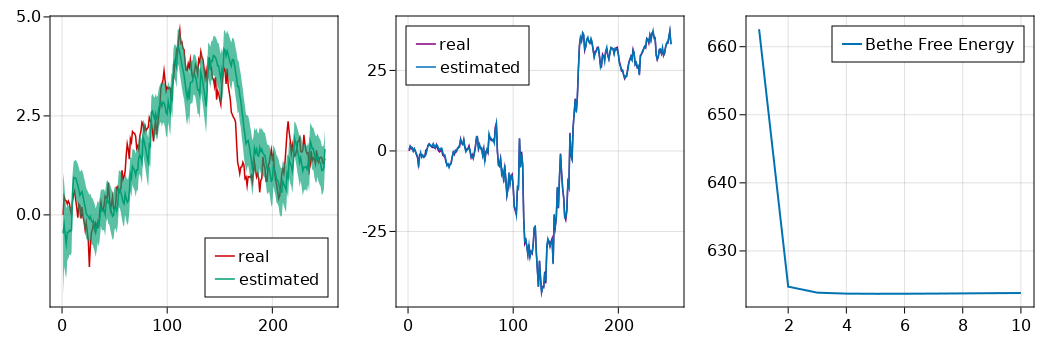

In [12]:
let 
    c = Makie.wong_colors()
    
    @unpack n, nitr = params

    f1    = Figure(resolution = (350, 350))
    f2    = Figure(resolution = (350, 350))
    f3    = Figure(resolution = (350, 350))
    range = 1:n
    grid  = 1:n

    ax1 = Makie.Axis(f1[1, 1])
    ax2 = Makie.Axis(f2[1, 1])
    ax3 = Makie.Axis(f3[1, 1])

    function plot_z(fig)

        lines!(fig, grid, z, color = :red3, label = "real")
        lines!(fig, grid, mean.(zm[range]), color = c[3], label = "estimated")
        band!(fig, grid, 
            mean.(zm) .- std.(zm),
            mean.(zm) .+ std.(zm),
            color = (c[3], 0.65)
        )

        axislegend(fig, labelsize = 16, position = :rb)
    end

    function plot_s(fig)

        lines!(fig, grid, s, color = :purple, label = "real")
        lines!(fig, grid, mean.(sm[range]), color = c[1], label = "estimated")
        band!(fig, grid, 
            mean.(sm) .- std.(sm),
            mean.(sm) .+ std.(sm),
            color = (c[1], 0.65)
        )

        axislegend(fig, labelsize = 16, position = :lt)
    end

    function plot_fe(fig)
        lines!(fig, 1:length(fe), fe, linewidth = 2, label = "Bethe Free Energy")
        axislegend(fig, labelsize = 16)
    end

    plot_z(ax1)
    plot_s(ax2)
    plot_fe(ax3)

    @saveplot f1 "hgf_inference_z"
    @saveplot f2 "hgf_inference_s"
    @saveplot f3 "hgf_inference_fe"

    local af = Figure(resolution = (350 * 3, 350))

    plot_z(Makie.Axis(af[1, 1]))
    plot_s(Makie.Axis(af[1, 2]))
    plot_fe(Makie.Axis(af[1, 3]))
    
    @show average_mse(z, zm)
    @show average_mse(s, sm)

    af
end

### Benchmark 

In [13]:
function run_benchmark(params)
    @unpack n, nitr, gh_n, seed, τ_z, τ_y, κ, ω = params

    z, s, y = generate_data(HGFModel(), params);

    data_source     = from(y)
    _, (fe, zm, sm) = inference(data_source, params);
    
    benchmark  = @benchmark inference(data_source, $params) seconds=120 setup=begin
        z, s, y     = generate_data(HGFModel(), $params);
        data_source = from(y)
    end
    
    z_amse = average_mse(z, zm)
    s_amse = average_mse(s, sm)
    
    emse_range = (seed):(seed + 10)
    
    emse = (1.0 / length(emse_range)) .* mapreduce(.+, emse_range) do _seed
        local cparams = deepcopy(params); cparams["seed"] = _seed;
        local z, s, y = generate_data(HGFModel(), cparams);
        local data_source = from(y)
        local _, (fe, zm, sm) = inference(data_source, cparams);
        local z_amse = average_mse(z, zm)
        local s_amse = average_mse(s, sm)
        return (z_amse, s_amse)
    end

    output = @strdict n nitr gh_n seed τ_z τ_y κ ω fe zm sm benchmark z_amse s_amse emse

    return output
end

run_benchmark (generic function with 1 method)

In [14]:
benchmark_params = dict_list(Dict(
    "n"     => [ 50, 100, 250, 500, 750, 1000, 1500, 2000, 5_000, 10_000, 20_000, 100_000 ],
    "nitr"  => [ 5, 10, 15, 20 ],
    "seed"  => 12,
    "τ_z"   => 20.0,
    "τ_y"   => 5.0,
    "κ"     => 1.0,
    "ω"     => 0.0,	
    "gh_n"  => 9
));

In [15]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
hgf_benchmarks = map(benchmark_params) do params
    path = datadir("benchmark", "hgf", "filtering")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_benchmark(p)
    end
    return result
end;

In [16]:
target_seed = 12
target_nitr = 15

15

In [17]:
let

    white_list   = [ "n", "seed", "nitr", "z_amse", "s_amse" ]
    special_list = [
        :min => (data) -> string(round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :mean => (data) -> string(round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :gctime => (data) -> string(round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%"),
        :z_emse_n => (data) -> string(round(data["emse"][1] / data["n"], digits = 2)),
        :s_emse_n => (data) -> string(round(data["emse"][2] / data["n"], digits = 2)),
    ]

    df = collect_benchmarks(hgf_benchmarks, white_list = white_list, special_list = special_list)

    query = @from row in df begin
        @where row.seed == target_seed && row.nitr == target_nitr
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime, row.z_amse, row.s_amse, row.z_emse_n, row.s_emse_n }
    end

    DataFrame(query) 
end

,n,min,gctime,z_amse,s_amse,z_emse_n,s_emse_n
,Int64,String,String,Float64,Float64,String,String
1,50,19.33ms,0.0%,44.9518,18.8858,0.89,0.36
2,100,38.2ms,0.0%,71.5268,37.0443,0.79,0.35
3,250,94.97ms,0.0%,178.384,95.533,0.75,0.35
4,500,196.06ms,0.0%,336.774,178.019,1.1,0.35
5,750,317.74ms,6.45%,500.95,282.933,1.47,0.34
6,1000,415.59ms,5.07%,663.533,381.49,1.39,0.33
7,1500,642.07ms,6.96%,945.088,580.792,1.42,0.33
8,2000,869.58ms,7.43%,1271.12,776.379,1.86,0.32
9,5000,2179.49ms,8.18%,7750.38,1729.16,4.51,0.31


In [18]:
target_n_itrs = [ 5, 10, 20 ]

3-element Vector{Int64}:
  5
 10
 20

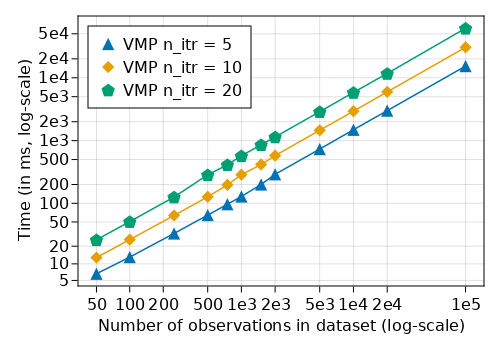

In [19]:
let
    local fig = Figure(resolution = (500, 350))

    local ax = Makie.Axis(fig[1, 1])

    ax.xlabel = "Number of observations in dataset (log-scale)"
    ax.ylabel = "Time (in ms, log-scale)"
    ax.xscale = Makie.pseudolog10
    ax.yscale = Makie.pseudolog10

    ax.xticks = (
        [ 50, 100, 200, 500, 1000, 2000, 5000, 10_000, 20_000, 100_000 ], 
        [ "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4", "2e4", "1e5" ]
    )

    ax.yticks = (
        [ 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5_000, 10_000, 20_000, 50_000 ], 
        [ "5", "10", "20", "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4", "2e4", "5e4" ]
    )

    local mshapes = [ :utriangle, :diamond, :pentagon ]

    for (mshape, target_n_itr) in zip(mshapes, target_n_itrs)
        local filtered = filter(hgf_benchmarks) do b
            return b["nitr"] === target_n_itr
        end

        local range      = map(f -> f["n"], filtered)
        local benchmarks = map(f -> f["benchmark"], filtered)
        local timings    = map(t -> t.time, minimum.(benchmarks)) ./ 1_000_000

        lines!(ax, range, timings)
        scatter!(ax, range, timings, marker = mshape, markersize = 16, label = "VMP n_itr = $(target_n_itr)" )
    end

    axislegend(ax, labelsize = 16, position = :lt)

    @saveplot fig "hgf_benchmark_observations"
end

In [20]:
target_ns = [ 100, 1000, 10000, 100000 ]

4-element Vector{Int64}:
    100
   1000
  10000
 100000

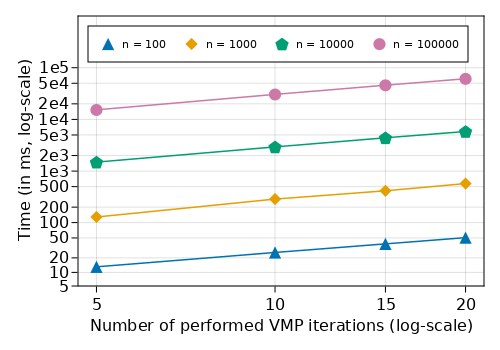

In [21]:
begin
    local fig = Figure(resolution = (500, 350))

    local ax = Makie.Axis(fig[1, 1])

    ax.xlabel = "Number of performed VMP iterations (log-scale)"
    ax.ylabel = "Time (in ms, log-scale)"
    ax.xscale = Makie.pseudolog10
    ax.yscale = Makie.pseudolog10

    ax.xticks = (
        [ 5, 10, 15, 20 ],
        string.([ 5, 10, 15, 20 ])
    )

    ax.yticks = (
        [ 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5_000, 10_000, 20_000, 50_000, 100_000 ], 
        [ "5", "10", "20", "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4", "2e4", "5e4", "1e5" ]
    )

    ylims!(ax, (5, 1e6 ))

    local mshapes = [ :utriangle, :diamond, :pentagon, :circle ]

    for (mshape, target_n) in zip(mshapes, target_ns)
        local filtered = filter(hgf_benchmarks) do b
            return b["n"] === target_n
        end
        
        local range      = map(f -> f["nitr"], filtered)
        local benchmarks = map(f -> f["benchmark"], filtered)
        local timings    = map(t -> t.time, minimum.(benchmarks)) ./ 1_000_000
        local ylim       = (1e0, 10maximum(timings))

        lines!(ax, range, timings)
        scatter!(ax, range, timings, marker = mshape, markersize = 16, label = "n = $(target_n)")
    end

    axislegend(ax, labelsize = 11, position = :lt, orientation = :horizontal)

    @saveplot fig "hgf_benchmark_iterations"
end

In [22]:
versioninfo()

Julia Version 1.6.4
Commit 35f0c911f4 (2021-11-19 03:54 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
